In [21]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Architecture

In [23]:
class Discriminator(nn.Module):
    def __init__(self, channel_img, feature_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img, feature_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(feature_d, feature_d*2, 4, 2, 1),
            self._block(feature_d*2, feature_d*4, 4, 2, 1),
            self._block(feature_d*4, feature_d*8, 4, 2, 1),
            nn.Conv2d(feature_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.disc(x)
    
    

In [24]:
class Generator(nn.Module):
    def __init__(self, z_dim, channel_img, feature_g): # z -> latent vector or noise
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, 1024, 4, 1, 0),
            self._block(1024, 512, 4, 2, 1),
            self._block(512, 256, 4, 2, 1),
            self._block(256, 128, 4, 2, 1),
            nn.ConvTranspose2d(128, channel_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    

    def forward(self, x):
        return self.gen(x)

In [25]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


## Data Preparation

In [26]:
LEARNING_RATE = 2e-4 
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 70
FEATURES_DISC = 128
FEATURES_GEN = 64
WORKERS = 4

In [27]:
BASE_DIR = "/home/jovyan/work/workspace/GAN-face-gen/"
IMAGE_DIR = "/home/jovyan/work/workspace/GAN-face-gen/data/face-images/"
# PARTITION_FILE = "/home/jovyan/work/workspace/GAN-face-gen/data/list_eval_partition.csv"
SPLIT_FILE = "/home/jovyan/work/workspace/GAN-face-gen/data/valid_split.csv"

In [28]:
partition_file = pd.read_csv(SPLIT_FILE)

train_df = partition_file[partition_file['Split'] == 0]
val_df = partition_file[partition_file['Split'] == 1]
test_df = partition_file[partition_file['Split'] == 2]

In [29]:
image_files = os.listdir(IMAGE_DIR)
image_files = [f for f in image_files if f.endswith(('.jpg', '.png'))]


In [30]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, data, transform=None):
        self.img_dir = img_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [31]:
transforms = transforms.Compose(
    [  
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)])
    ]
)


In [32]:
train_loader = DataLoader(
    FaceDataset(IMAGE_DIR, train_df, transform=transforms),
    batch_size=BATCH_SIZE,
    num_workers= WORKERS,
    shuffle=True
)

val_loader = DataLoader(
    FaceDataset(IMAGE_DIR, val_df, transform=transforms),
    batch_size=BATCH_SIZE,
    num_workers= WORKERS,
    shuffle=True
)

test_loader = DataLoader(
    FaceDataset(IMAGE_DIR, test_df, transform=transforms),
    batch_size=BATCH_SIZE,
    num_workers= WORKERS,
    shuffle=True
)

In [33]:
# def denormalize(img):
#     means = torch.tensor(normalise_means).view(3, 1, 1)
#     stds = torch.tensor(normalise_stds).view(3, 1, 1)
#     return img * stds + means

## Train

In [52]:
# model

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

initialize_weights(gen)
initialize_weights(disc)


In [68]:
optimize_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimize_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()
schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optimize_gen, NUM_EPOCHS, eta_min=1e-7)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(optimize_disc, NUM_EPOCHS, eta_min=1e-6)

In [69]:
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step=0

In [70]:
gen.load_state_dict(torch.load("../models/face-gen-70e-1.pth", map_location=device), strict=False)
disc.load_state_dict(torch.load('../models/discriminator/face-disc-test-1.pth', map_location=device), strict=False)

<All keys matched successfully>

In [71]:

def train():
    step =0
    all_lossD = []
    all_lossG = []
    all_val_lossG = []
    for epoch in range(NUM_EPOCHS):
        total_lossD = 0
        total_lossG = 0
        print("\nEpoch : ", epoch+1)
        gen.train()
        disc.train()
        for idx, image in tqdm(enumerate(train_loader), total=len(train_loader), unit="batch", desc="Training"):
            image = image.to(device)
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

            fake = gen(noise)

            # Training Discriminator
            disc_real = disc(image).reshape(-1)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake).reshape(-1)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            disc.zero_grad()
            lossD.backward(retain_graph=True)
            optimize_disc.step()

            # Training Generator
            output = disc(fake).reshape(-1)
            lossG = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            lossG.backward()
            optimize_gen.step()

            total_lossD += lossD.item()
            total_lossG += lossG.item()

            if idx % 100 == 0:

                with torch.no_grad():
                    fake = gen(fixed_noise)
                    img_grid_real = make_grid(image[:16], normalize=True)
                    img_grid_fake = make_grid(fake[:16], normalize=True)
                    writer_real.add_image("Real", img_grid_real, global_step=step)
                    writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                step += 1

        schedulerG.step()


        all_lossD.append(total_lossD/len(train_loader))
        all_lossG.append(total_lossG/len(train_loader))
        
        # Validation
        gen.eval()
        disc.eval()

        total_val_lossD = 0
        total_val_lossG = 0

        for idx, image in tqdm(enumerate(val_loader), total=len(val_loader), unit="batch", desc="Validation"):
            image = image.to(device)
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)

            fake = gen(noise)

            # disc_real = disc(image).reshape(-1)
            # lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            # disc_fake = disc(fake).reshape(-1)
            # lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            # lossD = (lossD_real + lossD_fake) / 2

            output = disc(fake).reshape(-1)
            lossG = criterion(output, torch.ones_like(output))

            total_val_lossD += lossD.item()
            total_val_lossG += lossG.item()
            

        print(f"Loss Disc: {total_lossD/len(train_loader):.4f}, loss Gen: {total_lossG/len(train_loader):.4f}, Validation-loss Gen: {total_val_lossG/len(val_loader):.4f}\n")

In [72]:
train()


Epoch :  1


Validation: 100%|██████████| 156/156 [00:05<00:00, 29.34batch/s]

Loss D: 0.4191, loss G: 2.1331, Validation loss G: 1.5661930976769862


Epoch :  2



Validation: 100%|██████████| 156/156 [00:04<00:00, 33.91batch/s]

Loss D: 0.4106, loss G: 2.1797, Validation loss G: 1.2743509526436145


Epoch :  3



Validation: 100%|██████████| 156/156 [00:04<00:00, 33.61batch/s]

Loss D: 0.3907, loss G: 2.2866, Validation loss G: 1.561867478566292


Epoch :  4



Validation: 100%|██████████| 156/156 [00:04<00:00, 33.25batch/s]

Loss D: 0.3697, loss G: 2.3764, Validation loss G: 1.870492439239453


Epoch :  5



Training:   3%|▎         | 36/1128 [00:03<01:38, 11.06batch/s]


KeyboardInterrupt: 

## Test

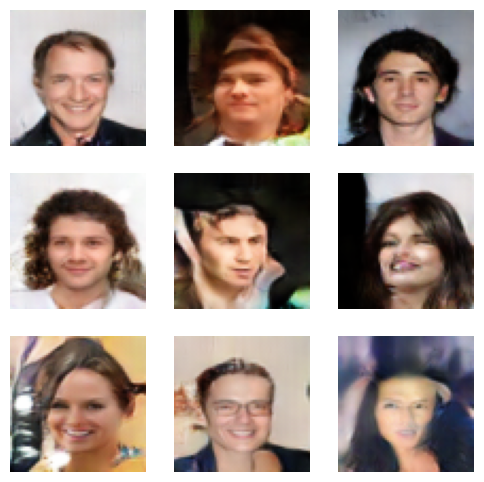

In [75]:
def denormalization(img):
    img = img / 2 + 0.5
    return img.clamp(0, 1)

gen.eval()
image_rows = 3
cols=3
noise = torch.randn(image_rows*cols, NOISE_DIM, 1, 1).to(device)
fake = gen(noise)

fig, axes = plt.subplots(image_rows, cols, figsize=(cols*2, image_rows*2))
for j in range(image_rows):
    for k in range(cols):
        fake_img = fake[j*cols+k].cpu().detach().permute(1, 2, 0).squeeze()
        # print(fake_img.shape)
        axes[j][k].imshow(denormalization(fake_img))
        axes[j][k].axis('off')
plt.show()


In [49]:
torch.save(gen.state_dict(), '../models/face-gen-70e-1.pth')
torch.save(disc.state_dict(), '../models/discriminator/face-disc-test-1.pth')

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])


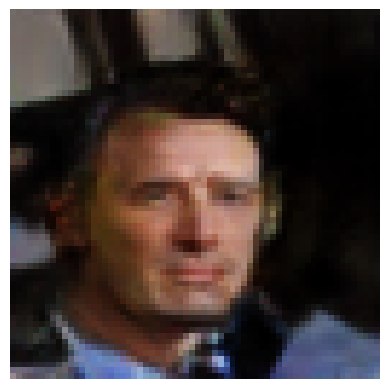

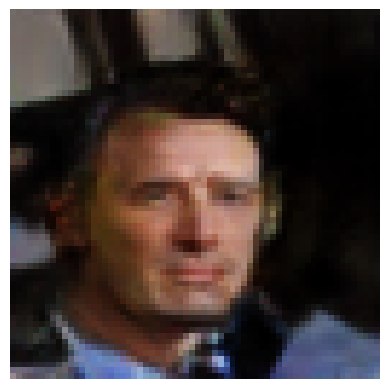

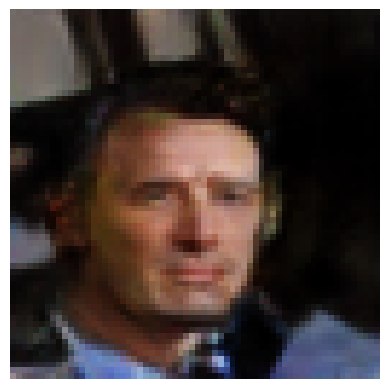

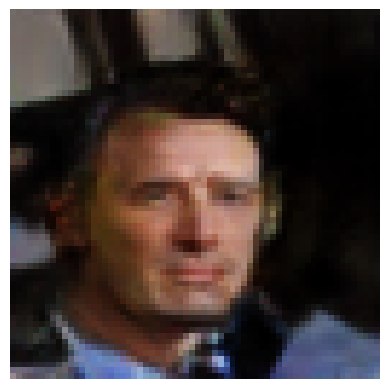

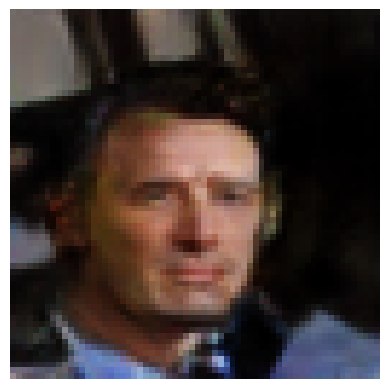

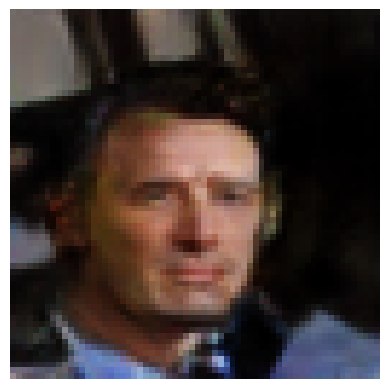

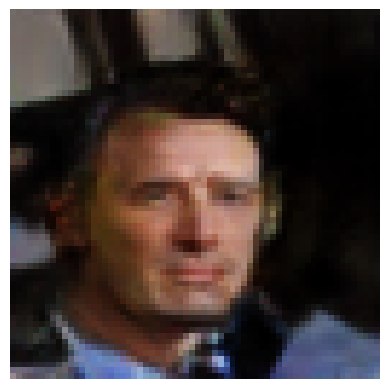

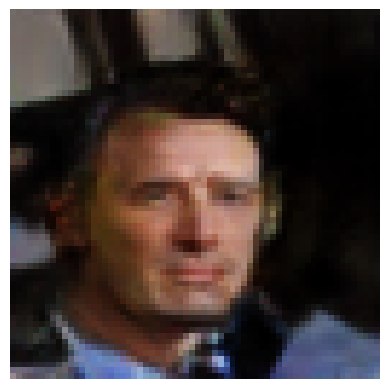

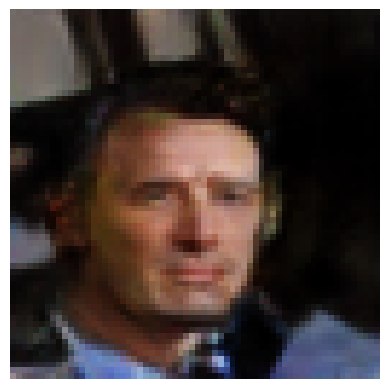

In [67]:
def generate():
    #a function that generates face, given a trained generator and tested by the discriminator as real
    gen.eval()
    image_rows = 3
    cols=3
    found = 0

    noise = torch.randn(1, NOISE_DIM, 1, 1).to(device)
    gen_Images = []
    while found < 9:
        fake = gen(noise)
        disc_fake = disc(fake)
        disc_fake = disc_fake.reshape(-1)
        print(disc_fake.shape)
        if disc_fake.item() > 0.05:
            found += 1
            fake_img = fake[0].cpu().detach().permute(1, 2, 0).squeeze()
            gen_Images.append(denormalization(fake_img))
        else:
            print("Not a face")
            print("\n")


    for fake_img in gen_Images:
        plt.imshow(fake_img)
        plt.axis('off')
        plt.show()

generate()
